In [1]:
d3_code_template = """
// 创建树状结构数据
var treeData = {{data}};

// 创建d3树布局
var margin = { top: 20, right: 90, bottom: 30, left: 90 },
  width = 960 - margin.left - margin.right,
  height = 500 - margin.top - margin.bottom;

var svg = d3
  .select("#tree")
  .append("g")
  .attr("transform", "translate(" + margin.left + "," + margin.top + ")");

var treemap = d3.tree().size([height, width]);

var nodes = d3.hierarchy(treeData);
nodes = treemap(nodes);

var link = svg
  .selectAll(".link")
  .data(nodes.descendants().slice(1))
  .enter()
  .append("path")
  .attr("class", "link")
  .attr("d", function (d) {
    return (
      "M" + d.y + "," + d.x +
      "C" + (d.y + d.parent.y) / 2 + "," + d.x +
      " " + (d.y + d.parent.y) / 2 + "," + d.parent.x +
      " " + d.parent.y + "," + d.parent.x
    );
  });

var node = svg
  .selectAll(".node")
  .data(nodes.descendants())
  .enter()
  .append("g")
  .attr("class", function (d) {
    return "node" + (d.children ? " node--internal" : " node--leaf");
  })
  .attr("transform", function (d) {
    return "translate(" + d.y + "," + d.x + ")";
  });

node.append("circle").attr("r", 10);

node
  .append("text")
  .attr("dy", ".35em")
  .attr("x", function (d) {
    return d.children ? -13 : 13;
  })
  .style("text-anchor", function (d) {
    return d.children ? "end" : "start";
  })
  .text(function (d) {
    return d.data.name;
  });
"""


In [4]:
html_template = """
<style>
.node circle {
  fill: #fff;
  stroke: steelblue;
  stroke-width: 1.5px;
}

.node text {
  font: 12px sans-serif;
}

.link {
  fill: none;
  stroke: #ccc;
  stroke-width: 1.5px;
}
</style>

<svg id="tree" width="960" height="500"></svg>

<script src="https://d3js.org/d3.v5.min.js"></script>

<script>
// 在这里插入d3.js代码
</script>
"""


In [5]:
from IPython.display import display, HTML

tree_data = {
  "name": "Root",
  "children": [
    {
      "name": "Node 1",
      "children": [
        { "name": "Node 1.1" },
        { "name": "Node 1.2" },
        { "name": "Node 1.3" },
      ]
    },
    {
      "name": "Node 2",
      "children": [
        { "name": "Node 2.1" },
        { "name": "Node 2.2" },
        { "name": "Node 2.3" }
      ]
    }
  ]
}

d3_code = d3_code_template.replace(r'{{data}}', str(tree_data)) 

html_content = html_template.replace("// 在这里插入d3.js代码", d3_code)
display(HTML(html_content))


'Hello, world!'

,A,B
0,1,4
1,2,5
2,3,6


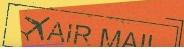

In [8]:
from IPython.display import display, HTML
import pandas as pd
 
# 显示一个字符串
display('Hello, world!')
 
# 显示一个 Pandas 数据框
df = pd.DataFrame({'A': [1, 2, 3], 'B': [4, 5, 6]})
display(df)
 
# 显示一张图片
from PIL import Image
img = Image.open('../test_data/tree/banner_img1_ann1.jpg')
display(img)
 
# 显示一段 HTML 代码
display(HTML('<h1>This is a heading</h1>'))

display(HTML("""
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <title>显示图片</title>
</head>
<body>
    <!-- 图片与HTML文件在同一目录下 -->
    <img src="../test_data/tree/logo_img1_ann2.jpg" alt="示例图片">
</body>
</html>
"""))

[0, -10.0, 12.0, 4.2]


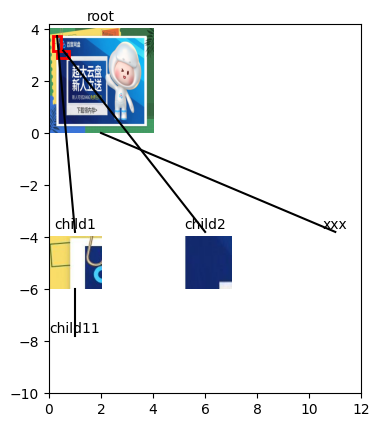

In [7]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np


def transform_bbox_to_ax(bbox, img_bound, img_wh):
    img_w, img_h = img_wh  # 图片的真实宽高
    # bbox是相对图片左上角点的图片像素偏移，转换成相对左下角点的偏移
    bbox = [bbox[0], img_h - bbox[1], bbox[2], img_h - bbox[3]]

    # scale to normalized coord
    scale_factor = np.array([1 / img_w, 1/ img_h] * 2)
    sbbox = np.array(bbox) * scale_factor  # scale to [0, 1]
    
    # ax_im_x1, ax_im_y1是图片左下角点在绘图坐标系的中的坐标
    ax_im_x1, ax_im_y1, ax_im_w, ax_im_h = img_bound
    sbbox = sbbox * np.array([ax_im_w, ax_im_h, ax_im_w, ax_im_h]) + np.array([ax_im_x1, ax_im_y1, ax_im_x1, ax_im_y1])
    return sbbox

def min_cover_bbox(boxa, boxb):
    ax1, ay1, ax2, ay2 = boxa
    bx1, by1, bx2, by2 = boxb
    x1, y1 = min(ax1, bx1), min(ay1, by1)
    x2, y2 = max(ax2, bx2), max(ay2, by2)
    return [x1, y1, x2, y2]


def draw_node(ax, node, xy, scale_xy=(1.0, 1.0), sep=(0.5, 1.0)):
    """
    ax坐标系是左下角为原点，图片坐标系是左上角为原点，这点不太一样。
    
    xy: 是根节点的左下角点在ax坐标系中的位置
    scale_xy： 是全图缩放比例

    不考虑scale的情况下，每张图片的大小被放到ax坐标系一个1*1的格子里
    sep: 水平和垂直方向上，两个节点的间隔是多少（单位是scale_xy*1）
    """
    if isinstance(scale_xy, (float, int)):
        scale_xy = (scale_xy, scale_xy)
    if isinstance(sep, (float, int)):
        sep = (sep, sep)
    horizontal_sep, vertical_sep = sep   # 水平和垂直方向上，两个节点的间隔是多少倍的图片大小
    im_x1, im_y1 = xy
    
    text, img, children = node['text'], node.get('image', None), node.get('children', [])

    node_scale = node.get('scale', 1.0)
    if isinstance(node_scale, (float, int)):
        node_scale = (node_scale, node_scale)
    text_sep = node.get('text_sep', 0.1)

    # 绘制节点的图片
    if img is not None:
        im = Image.open(img) if isinstance(img, str) else img
        bbox = node.get('bbox_of_parent', None)
        if bbox is not None:
            im = im.crop(bbox)
            
        # 1表示不考虑缩放的情况下，图片被放在1*1的格子里
        im_x2, im_y2 = im_x1 + 1 * scale_xy[0] * node_scale[0], im_y1 + 1 * scale_xy[1] * node_scale[1]  
        ax.imshow(im, aspect='equal', extent=(im_x1, im_x2, im_y1, im_y2))
    
    # 绘制文本描述框
    ax.text(xy[0] + scale_xy[0] * node_scale[0] / 2, xy[1] + scale_xy[1] * (node_scale[1] + text_sep), text, ha='center', va='bottom')

    # 当前节点在ax坐标系的范围 左下角点和
    im_bound_xywh = [im_x1, im_y1, scale_xy[0]*node_scale[0], scale_xy[1]*node_scale[1]]
    im_bound_xyxy = [im_x1, im_y1, im_x1+im_bound_xywh[2], im_y1+im_bound_xywh[3]]
    total_im_bound = [im_x1, im_y1, im_x1+scale_xy[0]*node_scale[0], im_y1+scale_xy[1] * (node_scale[1] + text_sep)]
    # 处理子节点
    for i, child in enumerate(children):
        # 计算子节点的左下角坐标
        child_xy = (
            im_x1 + i * scale_xy[0] * (1*node_scale[0]+horizontal_sep), 
            im_y1 - scale_xy[1] * (1*node_scale[1]+vertical_sep))     # 左下角点(x1, y1)
        
        # 在父节点中绘制红框
        bbox = child.get('bbox_of_parent', None)
        if bbox is not None:
            sbbox = transform_bbox_to_ax(bbox, im_bound_xywh, im.size)
            parent_rect = patches.Rectangle(sbbox[:2], sbbox[2]-sbbox[0], sbbox[3]-sbbox[1], linewidth=2, edgecolor='red', facecolor='none')
            ax.add_patch(parent_rect)
        else:
            sbbox = im_bound_xyxy
        
        # 绘制连接线
        parent_region_xy = ((sbbox[0] + sbbox[2]) / 2, sbbox[1])
        child_head_xy = (child_xy[0] + scale_xy[0] / 2, child_xy[1]+scale_xy[1]*1.1)            # (x1, y1)  => ((x1+x2)/2, y2) = (x1+w/2, y1+h)
        ax.plot([parent_region_xy[0], child_head_xy[0]], [parent_region_xy[1], child_head_xy[1]], 'k-')
        
        # 递归绘制子节点
        child_total_im_bound = draw_node(ax, child, child_xy, scale_xy=(scale_xy[0], scale_xy[1]))
        total_im_bound = min_cover_bbox(total_im_bound, child_total_im_bound)
          
    return total_im_bound

def visualize_tree(tree_data):
    fig, ax = plt.subplots()
    # ax.set_axis_off()
    total_bound = draw_node(ax, tree_data, xy=(0, 0), scale_xy=2.0)
    print(total_bound)
    ax.set_xlim(total_bound[0], total_bound[2])
    ax.set_ylim(total_bound[1], total_bound[3])
    plt.show()

# 示例数据


tree_data = {
    "text": "root",
    "image": "../test_data/tree/img1.jpg",
    "scale": 2.0,
    "children": [
        {
            "text": "child1",
            "image": "../test_data/tree/img1.jpg",
            "bbox_of_parent": [50, 50, 150, 150],  # 从根节点图片中裁剪区域
            "children": [
                {
                    "text": "child11"
                }
            ]
        },
        {
            "text": "child2",
            "image": "../test_data/tree/img1.jpg",
            "bbox_of_parent": [100, 150, 250, 200]  # 从根节点图片中裁剪区域
        },
        {
            "text": "xxx",
        }
    ]
}

visualize_tree(tree_data)
